In [1]:
import pandas as pd
import math
import numpy as np
from sklearn import tree
import scipy.stats
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
team_name="山形"
team_number=29
url=f"https://data.j-league.or.jp/SFMS01/search?competition_years=2019&competition_years=2018&competition_years=2017&competition_frame_ids=2&team_ids={team_number}&home_away_select=1&tv_relay_station_name="
fomerdata=pd.read_html(url,header=0)
data=fomerdata[0].drop(["大会","スタジアム"],axis=1)    
game_day=data.試合日
game_day=[s.replace("月・祝","月").replace("火・祝","火").replace("水・祝","水").replace("木・祝","木").replace("金・祝","金").replace("土・祝","土").replace("日・祝","日").replace("月・休","月") for s in game_day]
day=data.年度.astype(str)+"/"+game_day
day=pd.DataFrame({"年/月/日":day})
data=pd.concat([data,day],axis=1)
tenki=pd.read_excel(f"c:\\Users\\梅津魁秀\\Desktop\\卒業研究\\天気データ\\全国天気\\{team_name}.xlsx",skiprows=3)
tenki=tenki.fillna(0)
tenki=tenki.drop(tenki.index[[0]]).reset_index(drop=True)
tenki=tenki.drop(tenki.index[1095])
#1時間当たりの降水量情報を入れる
tenki2=pd.read_excel(f"c:\\Users\\梅津魁秀\\Desktop\\卒業研究\\1時間降水量の日最大\\{team_name}1.xlsx",skiprows=3)
tenki2=tenki2.drop(tenki2.index[[0,1,1097]]).reset_index(drop=True)
tenki["1時間降水量の最大(mm)"]=tenki2["1時間降水量の最大(mm)"]
google_trend=pd.read_csv("gt.csv").drop(["Unnamed: 0"],axis=1)
google_trend=google_trend[f"{team_name}"]
tenki=pd.concat([tenki,google_trend],axis=1)
tenki=tenki.rename(columns={f"{team_name}":"ホームトレンド"})
day2=tenki.年.round().astype(int).astype(str)+"/"+tenki.月.round().astype(int).astype(str).str.zfill(2)+"/"+tenki.日.round().astype(int).astype(str).str.zfill(2)+"("+tenki.曜日+")"
day2=pd.DataFrame({"年/月/日":day2})
tenki=pd.concat([tenki,day2],axis=1)
data=pd.merge(data,tenki[["年/月/日","平均気温(℃)","降水量の合計(mm)","日照時間(時間)","ホームトレンド","1時間降水量の最大(mm)"]],on="年/月/日",how="left")
sec=data.節.str.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
sec=sec.str.extract("(.+)節",expand=True).rename(columns={0:"節数"})
data=pd.concat([data,sec],axis=1)
rank=pd.read_csv("c:\\Users\\梅津魁秀\\anaconda3\\rank.csv").drop(["Unnamed: 0"],axis=1)
rank2=rank.rename(columns={"アウェイ":"ホーム"})
data=pd.merge(data,rank[["アウェイ","節数","年度","順位"]],on=["アウェイ","年度","節数"],how="left")
data=pd.merge(data,rank2[["ホーム","節数","年度","順位"]],on=["ホーム","年度","節数"],how="left")
data=data.rename(columns={"順位_x":"アウェイ順位","順位_y":"ホーム順位"})
data["節数"]=data["節数"].str.replace('第', '')
data["K/O時刻"]=data["K/O時刻"].str[:2]
score=data.スコア.str.split('-', expand=True)
score=score[[0,1]].astype(np.int64)
data["点数(ホームーアウェイ)"]=score[0]-score[1]
data=data.drop(["年度","節","試合日","ホーム","インターネット中継・TV放送","年/月/日","アウェイ","スコア"],axis=1)
temperature＿mean=int(data["平均気温(℃)"].mean())
#それぞれ平均を引いた値を出力する。
data["平均気温(℃)"]=round(data["平均気温(℃)"]-temperature＿mean,1)

In [3]:
data=data.astype('float64')
data

,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,1時間降水量の最大(mm),節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ)
0,14.0,9828.0,-9.8,1.5,8.2,24.0,1.5,4.0,16.0,10.0,0.0
1,14.0,6110.0,-11.8,0.0,7.0,21.0,0.0,5.0,5.0,11.0,0.0
2,17.0,4822.0,-7.2,0.5,1.5,34.0,0.5,7.0,9.0,10.0,1.0
3,14.0,4677.0,-4.4,3.0,1.7,34.0,1.5,8.0,3.0,10.0,1.0
4,14.0,7553.0,-0.9,0.0,12.7,27.0,0.0,11.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
58,14.0,8079.0,4.4,1.5,1.8,34.0,1.5,34.0,7.0,4.0,-1.0
59,14.0,5415.0,-3.7,0.5,0.1,45.0,0.5,36.0,22.0,3.0,2.0
60,13.0,7404.0,-2.2,2.0,1.6,67.0,1.0,38.0,16.0,2.0,3.0
61,14.0,8911.0,-7.3,0.0,6.1,73.0,0.0,40.0,12.0,4.0,-2.0


In [4]:
#入場者数の標準化
#標準偏差s
#標準化参考資料　https://bellcurve.jp/statistics/course/19647.html
s=np.std(data["入場者数"])
#平均x
x=sum(data["入場者数"])/len(data["入場者数"])
#標準化して更新する
data["入場者数"]=(data["入場者数"]-x)/s
data

,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,1時間降水量の最大(mm),節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ)
0,14.0,1.026640,-9.8,1.5,8.2,24.0,1.5,4.0,16.0,10.0,0.0
1,14.0,-0.432777,-11.8,0.0,7.0,21.0,0.0,5.0,5.0,11.0,0.0
2,17.0,-0.938352,-7.2,0.5,1.5,34.0,0.5,7.0,9.0,10.0,1.0
3,14.0,-0.995269,-4.4,3.0,1.7,34.0,1.5,8.0,3.0,10.0,1.0
4,14.0,0.133640,-0.9,0.0,12.7,27.0,0.0,11.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
58,14.0,0.340109,4.4,1.5,1.8,34.0,1.5,34.0,7.0,4.0,-1.0
59,14.0,-0.705584,-3.7,0.5,0.1,45.0,0.5,36.0,22.0,3.0,2.0
60,13.0,0.075153,-2.2,2.0,1.6,67.0,1.0,38.0,16.0,2.0,3.0
61,14.0,0.666692,-7.3,0.0,6.1,73.0,0.0,40.0,12.0,4.0,-2.0


In [5]:
m1=np.array(data["平均気温(℃)"])
m2=np.array(data["節数"])
m3=np.array(data["アウェイ順位"])
m4=np.array(data["ホーム順位"])
m5=np.array(data["ホームトレンド"])
m6=np.array(data["1時間降水量の最大(mm)"])

In [6]:
plus_list=[1]*63
print(m1)
m1_abs=abs(m1)
print(m1_abs)
r_m1=np.array([10])
judge_m1=np.digitize(m1_abs,r_m1)
judge_m1=judge_m1+plus_list
print(judge_m1)
print(collections.Counter(judge_m1))

[ -9.8 -11.8  -7.2  -4.4  -0.9  -0.7  -0.9   6.4   1.8   5.1   8.5  12.1
   5.7   7.8   2.5   5.4   3.8   0.   -2.2  -3.6 -14.5 -14.5 -15.   -9.3
  -5.5  -1.7   3.7   0.4   1.9   1.6   5.5   9.2  12.4  11.8  10.   11.2
   4.8   5.6   2.   -3.8  -2.1  -7.5 -11.8 -14.5  -8.1  -3.8   1.2  -0.6
   7.4   4.5   2.3   3.7   6.7  11.4  13.   10.5   8.6   8.9   4.4  -3.7
  -2.2  -7.3  -3.9]
[ 9.8 11.8  7.2  4.4  0.9  0.7  0.9  6.4  1.8  5.1  8.5 12.1  5.7  7.8
  2.5  5.4  3.8  0.   2.2  3.6 14.5 14.5 15.   9.3  5.5  1.7  3.7  0.4
  1.9  1.6  5.5  9.2 12.4 11.8 10.  11.2  4.8  5.6  2.   3.8  2.1  7.5
 11.8 14.5  8.1  3.8  1.2  0.6  7.4  4.5  2.3  3.7  6.7 11.4 13.  10.5
  8.6  8.9  4.4  3.7  2.2  7.3  3.9]
[1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1
 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1]
Counter({1: 49, 2: 14})


In [7]:
print(m2)
r_m2=np.array([14,28])
judge_m2=np.digitize(m2,r_m2)
judge_m2=judge_m2+plus_list
print(judge_m2)
print(m3)
r_m3=np.array([8,15])
judge_m3=np.digitize(m3,r_m3)
judge_m3=judge_m3+plus_list
print(judge_m3)
print(m4)
r_m4=np.array([8,15])
judge_m4=np.digitize(m4,r_m4)
judge_m4=judge_m4+plus_list
print(judge_m4)
print(m5)
r_m5=np.array([34,67])
judge_m5=np.digitize(m5,r_m5)
judge_m5=judge_m5+plus_list
print(judge_m5)
print(m6)
r_m6=np.array([1])
judge_m6=np.digitize(m6,r_m6)
judge_m6=judge_m6+plus_list
print(judge_m6)

[ 4.  5.  7.  8. 11. 12. 14. 15. 18. 20. 21. 24. 27. 29. 31. 32. 34. 35.
 37. 39. 42.  4.  5.  7.  9. 11. 13. 14. 16. 18. 20. 21. 24. 25. 28. 30.
 31. 33. 35. 38. 39. 42.  4.  5.  8. 10. 12. 13. 15. 16. 18. 20. 22. 24.
 25. 27. 29. 30. 34. 36. 38. 40. 42.]
[1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3]
[16.  5.  9.  3. 13.  3. 10. 20. 21.  6. 16.  1. 18.  9. 10. 17. 20.  3.
  8. 16. 18.  5.  5.  4. 21. 12. 20. 14. 18. 14. 17. 11. 16. 10.  6. 17.
 21. 16.  1.  5. 11.  2. 13.  1. 16. 15. 11. 17.  8. 21.  3.  5.  1. 12.
 19. 10. 21.  2.  7. 22. 16. 12. 18.]
[3 1 2 1 2 1 2 3 3 1 3 1 3 2 2 3 3 1 2 3 3 1 1 1 3 2 3 2 3 2 3 2 3 2 1 3 3
 3 1 1 2 1 2 1 3 3 2 3 2 3 1 1 1 2 3 2 3 1 1 3 3 2 3]
[10. 11. 10. 10. 15. 16. 13. 10.  8. 10. 10. 14. 10. 13. 13. 12. 13. 13.
 12. 13. 11. 14. 15. 19. 11. 15. 18. 19. 14. 11.  9.  7. 11.  9.  9. 12.
 10. 10.  9. 10. 13. 12.  5.  5.  1.  4.  2.  1.  2.  1.  1.  1.  2.  4.
  5.  4. 

In [8]:
classification=[]
for t in range(len(judge_m1)):
    classification.append(str(judge_m6[t])+str(judge_m1[t])+str(judge_m2[t])
             +str(judge_m3[t])+str(judge_m4[t])+str(judge_m5[t]))

print(len(classification))    
print(classification)

63
['211321', '121121', '111222', '211122', '111231', '111131', '112221', '112322', '112322', '212121', '212321', '122121', '212321', '113221', '113221', '113321', '113321', '113121', '113221', '213321', '223321', '121121', '221131', '111131', '211321', '111231', '111331', '112231', '112321', '112221', '112321', '212211', '122322', '122221', '123121', '223322', '213321', '113321', '213121', '113122', '113221', '113121', '121212', '221111', '111312', '111311', '111211', '111312', '112211', '112312', '212112', '212112', '112112', '222212', '122311', '122211', '113311', '113111', '213112', '113312', '213313', '113213', '113313']


In [9]:
data["judge"]=classification
data

,K/O時刻,入場者数,平均気温(℃),降水量の合計(mm),日照時間(時間),ホームトレンド,1時間降水量の最大(mm),節数,アウェイ順位,ホーム順位,点数(ホームーアウェイ),judge
0,14.0,1.026640,-9.8,1.5,8.2,24.0,1.5,4.0,16.0,10.0,0.0,211321
1,14.0,-0.432777,-11.8,0.0,7.0,21.0,0.0,5.0,5.0,11.0,0.0,121121
2,17.0,-0.938352,-7.2,0.5,1.5,34.0,0.5,7.0,9.0,10.0,1.0,111222
3,14.0,-0.995269,-4.4,3.0,1.7,34.0,1.5,8.0,3.0,10.0,1.0,211122
4,14.0,0.133640,-0.9,0.0,12.7,27.0,0.0,11.0,13.0,15.0,0.0,111231
...,...,...,...,...,...,...,...,...,...,...,...,...
58,14.0,0.340109,4.4,1.5,1.8,34.0,1.5,34.0,7.0,4.0,-1.0,213112
59,14.0,-0.705584,-3.7,0.5,0.1,45.0,0.5,36.0,22.0,3.0,2.0,113312
60,13.0,0.075153,-2.2,2.0,1.6,67.0,1.0,38.0,16.0,2.0,3.0,213313
61,14.0,0.666692,-7.3,0.0,6.1,73.0,0.0,40.0,12.0,4.0,-2.0,113213


In [10]:
data=data.drop(columns={"K/O時刻","平均気温(℃)","降水量の合計(mm)","日照時間(時間)","ホームトレンド","節数","アウェイ順位","ホーム順位","点数(ホームーアウェイ)","1時間降水量の最大(mm)"})
data=data.astype('float64')
data

,入場者数,judge
0,1.026640,211321.0
1,-0.432777,121121.0
2,-0.938352,111222.0
3,-0.995269,211122.0
4,0.133640,111231.0
...,...,...
58,0.340109,213112.0
59,-0.705584,113312.0
60,0.075153,213313.0
61,0.666692,113213.0


In [11]:
# all_team_judge=pd.read_csv("all_team_judge.csv").drop(columns={"Unnamed: 0","y1","y2","y3","y4","y5","y6"})
# all_team_judge

,visitors,judge
0,-0.113982,113331
1,1.129536,112113
2,0.026304,113233
3,-0.094399,211323
4,1.167700,213313
...,...,...
226,0.627446,121221
227,0.744631,122131
228,0.100322,111111
229,-0.570490,211332


In [12]:
# data3=pd.merge(data,all_team_judge[["visitors","judge"]],on="judge",how="left").reindex(columns=["judge","入場者数","visitors"])
# data3

,judge,入場者数,visitors
0,211321.0,1.026640,-0.527537
1,121121.0,-0.432777,0.099119
2,111222.0,-0.938352,-0.199920
3,211122.0,-0.995269,-0.786138
4,111231.0,0.133640,0.081987
...,...,...,...
58,213112.0,0.340109,0.372972
59,113312.0,-0.705584,0.599251
60,213313.0,0.075153,1.167700
61,113213.0,0.666692,1.971513


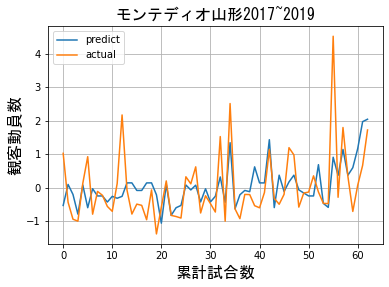

In [13]:
# import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties 
# fp = FontProperties(fname=r'C:\WINDOWS\Fonts\msgothic.ttc', size=16)
# predict=data3["visitors"]
# actual=data3["入場者数"]
# xx=[i for i in range(63)]
# fig = plt.figure()
# plt.title("モンテディオ山形2017~2019",fontproperties=fp)
# plt.grid(True)
# plt.xlabel("累計試合数",fontproperties=fp)
# plt.ylabel("観客動員数",fontproperties=fp)
# plt.plot(xx,predict,label="predict")
# plt.plot(xx,actual,label="actual")
# plt.legend()
# plt.show()

In [14]:
# data3["difference"]=data3["入場者数"]-data3["visitors"]
# data3

,judge,入場者数,visitors,difference
0,211321.0,1.026640,-0.527537,1.554177
1,121121.0,-0.432777,0.099119,-0.531896
2,111222.0,-0.938352,-0.199920,-0.738432
3,211122.0,-0.995269,-0.786138,-0.209131
4,111231.0,0.133640,0.081987,0.051653
...,...,...,...,...
58,213112.0,0.340109,0.372972,-0.032863
59,113312.0,-0.705584,0.599251,-1.304835
60,213313.0,0.075153,1.167700,-1.092547
61,113213.0,0.666692,1.971513,-1.304821


In [15]:
# もう一度イベント情報を整理してみる。
# イベント情報からその日のイベントを自分なりに評価

In [16]:
# #標準化を戻す
# #先程求めた値を使うがもう一度確認する。

# print("標準偏差   "+ str(s))
# print("平均     "+str(x))

# data3["入場者数_act"]=data3["入場者数"]*s+x
# data3["visitors_act"]=data3["visitors"]*s+x
# data3.to_csv("diff.csv")
# data3

標準偏差   2547.59303660756
平均     7212.539682539683


,judge,入場者数,visitors,difference,入場者数_act,visitors_act
0,211321.0,1.026640,-0.527537,1.554177,9828.0,5868.589207
1,121121.0,-0.432777,0.099119,-0.531896,6110.0,7465.055796
2,111222.0,-0.938352,-0.199920,-0.738432,4822.0,6703.225459
3,211122.0,-0.995269,-0.786138,-0.209131,4677.0,5209.779447
4,111231.0,0.133640,0.081987,0.051653,7553.0,7421.409648
...,...,...,...,...,...,...
58,213112.0,0.340109,0.372972,-0.032863,8079.0,8162.720627
59,113312.0,-0.705584,0.599251,-1.304835,5415.0,8739.187371
60,213313.0,0.075153,1.167700,-1.092547,7404.0,10187.364092
61,113213.0,0.666692,1.971513,-1.304821,8911.0,12235.152039


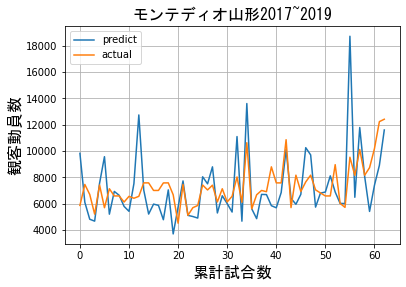

In [17]:
# fig = plt.figure()
# plt.title("モンテディオ山形2017~2019",fontproperties=fp)
# plt.grid(True)
# plt.xlabel("累計試合数",fontproperties=fp)
# plt.ylabel("観客動員数",fontproperties=fp)
# plt.plot(xx,data3["入場者数_act"],label="predict")
# # plt.legend(["実測値"], prop={"family":"MS Gothic"})
# plt.plot(xx,data3["visitors_act"],label="actual")
# # plt.legend(["予測値"], prop={"family":"MS Gothic"})
# plt.legend()
# plt.show()

# fig.savefig("img.png")

In [18]:
# data3["dif"]=data3["入場者数_act"]-data3["visitors_act"]
# print(data3["dif"])
# data3["dif"].to_csv("dif.csv")

0     3959.410793
1    -1355.055796
2    -1881.225459
3     -532.779447
4      131.590352
         ...     
58     -83.720627
59   -3324.187371
60   -2783.364092
61   -3324.152039
62    -816.816693
Name: dif, Length: 63, dtype: float64


In [19]:
all_team_shiken=pd.read_csv("all_team_shiken.csv")
all_team_shiken

,Unnamed: 0,judge,predict
0,0,113331.0,-0.130078
1,1,112113.0,1.212005
2,2,113233.0,0.126518
3,3,211323.0,-0.194757
4,4,213313.0,0.907600
...,...,...,...
226,226,121221.0,0.029281
227,227,122131.0,0.277149
228,228,111111.0,0.020719
229,229,211332.0,-0.677787


In [20]:
data2=pd.merge(data,all_team_shiken[["predict","judge"]],on="judge",how="left").reindex(columns=["judge","predict","入場者数"])
data2

,judge,predict,入場者数
0,211321.0,-0.627795,1.026640
1,121121.0,-0.007923,-0.432777
2,111222.0,-0.099959,-0.938352
3,211122.0,-0.685792,-0.995269
4,111231.0,-0.037887,0.133640
...,...,...,...
58,213112.0,0.771368,0.340109
59,113312.0,0.498985,-0.705584
60,213313.0,0.907600,0.075153
61,113213.0,1.350971,0.666692


In [21]:
data2["judge"]=data2["judge"].round().astype(int)
data2["predict"]=data2["predict"]*s+x
data2["入場者数"]=data2["入場者数"]*s+x
data2["差"]=data2["入場者数"]-data2["predict"]
data2

,judge,predict,入場者数,差
0,211321,5613.173651,9828.0,4214.826349
1,121121,7192.356307,6110.0,-1082.356307
2,111222,6957.885246,4822.0,-2135.885246
3,211122,5465.421698,4677.0,-788.421698
4,111231,7116.019205,7553.0,436.980795
...,...,...,...,...
58,213112,9177.672210,8079.0,-1098.672210
59,113312,8483.749501,5415.0,-3068.749501
60,213313,9524.735686,7404.0,-2120.735686
61,113213,10654.264887,8911.0,-1743.264887


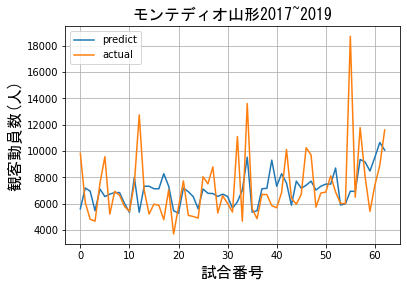

In [22]:
fig = plt.figure()
plt.title("モンテディオ山形2017~2019",fontproperties=fp)
plt.grid(True)
plt.xlabel("試合番号",fontproperties=fp)
plt.ylabel("観客動員数(人)",fontproperties=fp)
plt.plot(xx,data2["predict"],label="predict")
plt.plot(xx,data2["入場者数"],label="actual")
plt.legend()
plt.show()

fig.savefig("imging.png")

In [23]:
data2["差"].to_csv("kannkyakusa.csv")
data2["差"]

0     4214.826349
1    -1082.356307
2    -2135.885246
3     -788.421698
4      436.980795
         ...     
58   -1098.672210
59   -3068.749501
60   -2120.735686
61   -1743.264887
62    1528.518309
Name: 差, Length: 63, dtype: float64